In [1]:
!pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.0 MB/s eta 0:00:00


In [2]:
from functools import partial 
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [3]:
from neuralforecast import NeuralForecast
from ray import tune
from neuralforecast.auto import AutoLSTM, AutoNLinear
import pandas as pd
import pprint
from neuralforecast.losses.numpy import mae, mse
import matplotlib.pyplot as plt
import os
import glob
import torch
import torch.optim as optim


df = pd.DataFrame(columns=['coordinates','date','temperature'])

for file in glob.glob(os.path.join("/kaggle/input/global-temperature/temperature", "*.csv")) :
    temp_df = pd.read_csv(file, header = 0)
    df = pd.concat([df, temp_df], ignore_index=True)
df['date'] = pd.to_datetime(df['date'])
df = df.rename(columns={"coordinates": "unique_id", "date": "ds", "temperature": "y"})  # 重命名欄位以符合模型格式
df.loc[df['ds'] == '2024-07-01', 'y'] = (df.loc[df['ds'] == '2024-07-01', 'y'] * 31 + 2997) / 28

print(df)

horizon = 12
config = {
       "learning_rate": tune.choice([1e-4]),                                     # Initial Learning rate
       "max_steps": tune.choice([24000]),                                         # Number of steps
       "input_size": tune.choice([12]),                                 # input_size = multiplier * horizon
       "val_check_steps": tune.choice([2400]),                                    # Compute validation every 100 epochs
       "random_seed": 2486,
       "optimizer": optim.AdamW,
}

models = [AutoNLinear(h=horizon, config=config)]
nf = NeuralForecast(models=models, freq='M')
n_time = len(df.ds.unique())
val_size = int(.2 * n_time)
test_size = horizon
Y_hat_df = nf.cross_validation(df=df, val_size=val_size, test_size=test_size, n_windows=None)

(_train_tune pid=380) /opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=380)   return torch.load(io.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 13:  11%|█▏        | 21/183 [00:00<00:01, 142.91it/s, v_num=0, train_loss_step=2.150, train_loss_epoch=2.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  11%|█▏        | 21/183 [00:00<00:00, 256.94it/s]
(_train_tune pid=380) 
Validation DataLoader 0:  26%|██▌       | 48/183 [00:00<00:00, 259.02it/s]
(_train_tune pid=380) 
Validation DataLoader 0:  40%|████      | 74/183 [00:00<00:00, 258.80it/s]
(_train_tune pid=380) 
Validation DataLoader 0:  41%|████      | 75/183 [00:00<00:00, 258.28it/s]
(_train_tune pid=380) 
Validation DataLoader 0:  55%|█████▌    | 101/183 [00:00<00:00, 256.33it/s]
(_train_tune pid=380) 
Validation DataLoader 0:  68%|██████▊   | 125/183 [00:00<00:00, 251.03it/s]
(_train_tune pid=380) 
Validation DataLoader 0:  81%|████████▏ | 149/183 [00:00<00:00, 249.20it/s]
(_train_tune pid=380) 
Validation DataLoader 0:  82%|████████▏ | 150/183 [00:00<00:00, 249.25it/s]
(_train_tune pid=380) 

/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Epoch 26:  23%|██▎       | 42/183 [00:00<00:00, 146.92it/s, v_num=0, train_loss_step=1.850, train_loss_epoch=1.720, valid_loss=1.920]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   7%|▋         | 12/183 [00:00<00:00, 254.65it/s]
(_train_tune pid=380) 
Validation DataLoader 0:  21%|██        | 38/183 [00:00<00:00, 253.57it/s]
(_train_tune pid=380) 
Validation DataLoader 0:  35%|███▍      | 64/183 [00:00<00:00, 251.76it/s]
(_train_tune pid=380) 
Validation DataLoader 0:  49%|████▉     | 90/183 [00:00<00:00, 252.66it/s]
(_train_tune pid=380) 
Validation DataLoader 0:  63%|██████▎   | 116/183 [00:00<00:00, 252.31it/s]
(_train_tune pid=380) 
Validation DataLoader 0:  77%|███████▋  | 141/183 [00:00<00:00, 250.77it/s]
(_train_tune pid=380) 
Validation DataLoader 0:  78%|███████▊  | 142/183 [00:00<00:00, 250.65it/s]
(_train_tune pid=380) 
Validation DataLoader 0:  92%|█████████▏| 168/183 [00:00<00:00, 251.75it/s]
(_train_tune pid=380) 
Validation DataLoader 0:  92%|██

(_train_tune pid=481) /opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=481)   return torch.load(io.

Epoch 13:  11%|█▏        | 21/183 [00:00<00:01, 151.87it/s, v_num=0, train_loss_step=2.150, train_loss_epoch=2.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  11%|█▏        | 21/183 [00:00<00:00, 245.55it/s]
(_train_tune pid=481) 
Validation DataLoader 0:  26%|██▌       | 47/183 [00:00<00:00, 248.70it/s]
(_train_tune pid=481) 
Validation DataLoader 0:  40%|████      | 74/183 [00:00<00:00, 252.40it/s]
(_train_tune pid=481) 
Validation DataLoader 0:  55%|█████▌    | 101/183 [00:00<00:00, 255.58it/s]
(_train_tune pid=481) 
Validation DataLoader 0:  56%|█████▌    | 102/183 [00:00<00:00, 255.43it/s]
(_train_tune pid=481) 
Validation DataLoader 0:  70%|██████▉   | 128/183 [00:00<00:00, 255.07it/s]
(_train_tune pid=481) 
Validation DataLoader 0:  85%|████████▍ | 155/183 [00:00<00:00, 255.91it/s]
(_train_tune pid=481) 
Validation DataLoader 0:  99%|█████████▉| 182/183 [00:00<00:00, 257.33it/s]
(_train_tune pid=481) 
Validation DataLoader 0: 100%|██████████| 183/183

2024-10-05 16:38:06,979	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-10-05 16:38:06,986	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-10-05_16-33-44' in 0.0061s.


Epoch 26:  23%|██▎       | 42/183 [00:00<00:01, 136.51it/s, v_num=0, train_loss_step=1.850, train_loss_epoch=1.720, valid_loss=1.920]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   3%|▎         | 5/183 [00:00<00:00, 252.15it/s]
(_train_tune pid=481) 
Validation DataLoader 0:  15%|█▌        | 28/183 [00:00<00:00, 231.46it/s]
(_train_tune pid=481) 
Validation DataLoader 0:  16%|█▌        | 29/183 [00:00<00:00, 230.07it/s]
(_train_tune pid=481) 
Validation DataLoader 0:  30%|██▉       | 54/183 [00:00<00:00, 238.53it/s]
(_train_tune pid=481) 
Validation DataLoader 0:  30%|███       | 55/183 [00:00<00:00, 237.98it/s]
(_train_tune pid=481) 
Validation DataLoader 0:  43%|████▎     | 79/183 [00:00<00:00, 236.41it/s]
(_train_tune pid=481) 
Validation DataLoader 0:  57%|█████▋    | 104/183 [00:00<00:00, 237.40it/s]
(_train_tune pid=481) 
Validation DataLoader 0:  70%|███████   | 129/183 [00:00<00:00, 238.99it/s]
(_train_tune pid=481) 
Validation DataLoader 0:  71%|█████

2024-10-05 16:38:07,821	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="/root/ray_results/_train_tune_2024-10-05_16-33-44", trainable=...)
2024-10-05 16:38:07,835	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 8 trial(s):
- _train_tune_6623f_00002: FileNotFoundError('Could not fetch metrics for _train_tune_6623f_00002: both result.json and progress.csv were not found at /root/ray_results/_train_tune_2024-10-05_16-33-44/_train_tune_6623f_00002_2_input_size=12,learning_rate=0.0001,max_steps=24000,val_check_steps=2400_2024-10-05_16-34-03')
- _train_tune_6623f_00003: FileNotFoundError('Could not fetch metrics for _train_tune_6623f_00003: both result.json and progress.csv were not found at /root/ray_results/_train_tune_2024-10-05_16-33-44/_train_tune_6623f_00003_3_input_size=12,learning_rate=0.0001,max_steps=24000,val_check_steps=2400_2024-10-05_16-34-03')
- _train_tune_6623f_00004: 

(_train_tune pid=481) 
Validation DataLoader 0:  99%|█████████▉| 181/183 [00:00<00:00, 240.93it/s]
(_train_tune pid=481) 
Validation DataLoader 0: 100%|██████████| 183/183 [00:00<00:00, 240.45it/s]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [8]:
y_true = Y_hat_df.y.values
y_hat = Y_hat_df['AutoNLinear'].values
print(nf.models[0].results.get_best_result().config)
n_series = len(df.unique_id.unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)

model = nf.models[0].model
model = nf.save(path='/kaggle/working/model', overwrite=True)

{'learning_rate': 0.0001, 'max_steps': 24000, 'input_size': 12, 'val_check_steps': 2400, 'random_seed': 2486, 'optimizer': <class 'torch.optim.adamw.AdamW'>, 'h': 12, 'loss': MAE(), 'valid_loss': MAE()}


Parsed results
2. y_true.shape (n_series, n_windows, n_time_out):	 (5851, 1, 12)
2. y_hat.shape  (n_series, n_windows, n_time_out):	 (5851, 1, 12)
MAE:  1.6255515673063397
MSE:  4.349865186699227


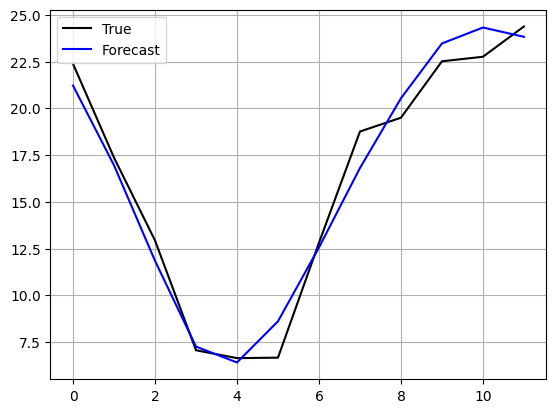

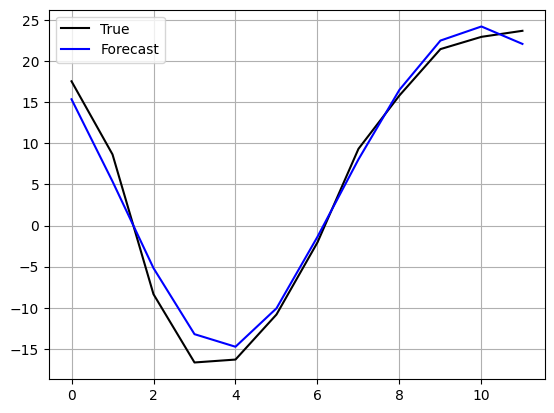

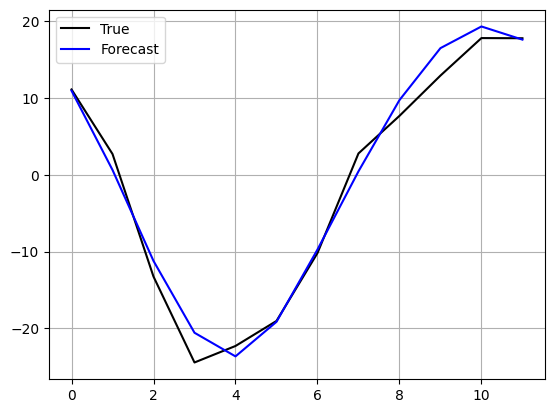

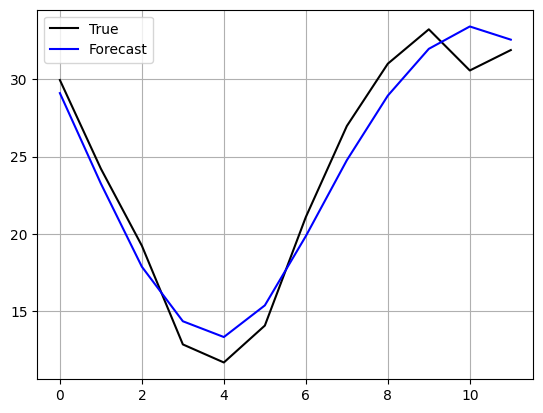

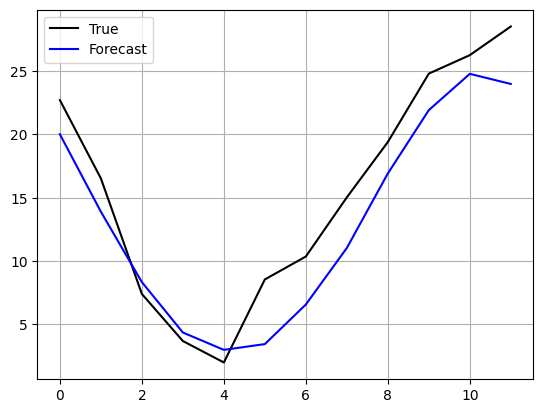

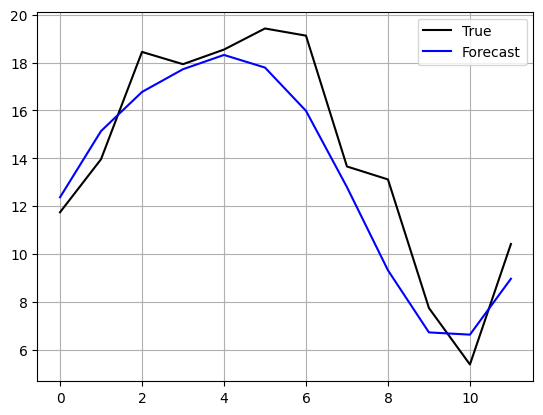

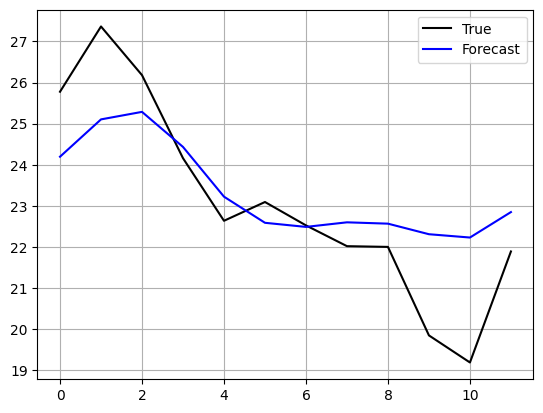

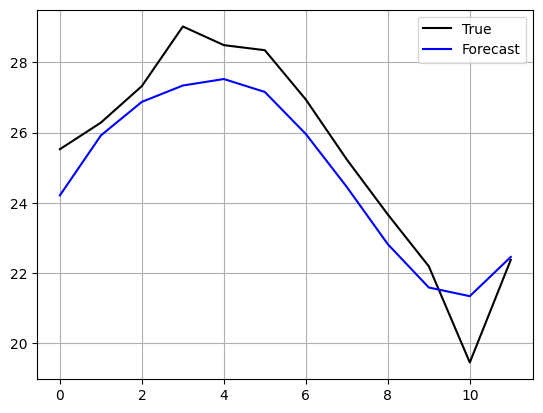

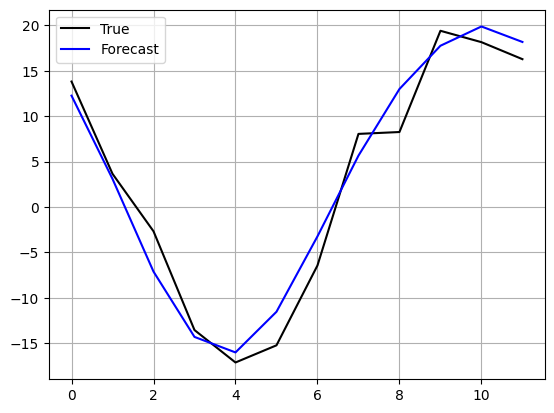

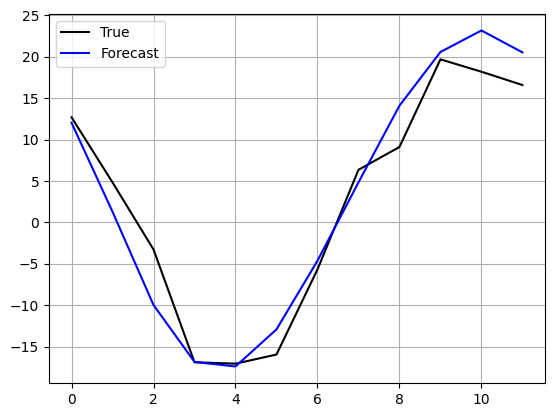

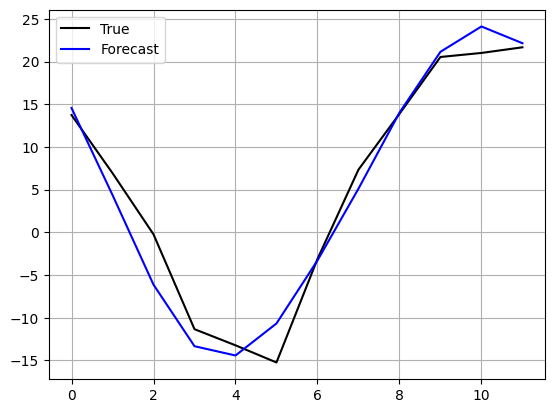

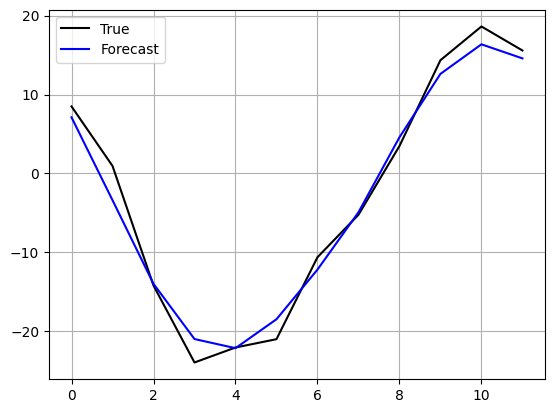

<Figure size 640x480 with 0 Axes>

In [9]:
print('Parsed results')
print('2. y_true.shape (n_series, n_windows, n_time_out):\t', y_true.shape)
print('2. y_hat.shape  (n_series, n_windows, n_time_out):\t', y_hat.shape)
print('MAE: ', mae(y_hat, y_true))
print('MSE: ', mse(y_hat, y_true))
for i in range (2413, 5881, 300):
    plt.plot(y_true[i,0,:], c='black', label='True')
    plt.plot(y_hat[i,0,:], c='blue', label='Forecast')
    plt.legend()
    plt.grid()
    plt.show()
    plt.clf()